In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c neurips-open-polymer-prediction-2025
!unzip /content/neurips-open-polymer-prediction-2025.zip
!rm /content/neurips-open-polymer-prediction-2025.zip

Mounted at /content/drive
  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 313MB/s]
Archive:  /content/neurips-open-polymer-prediction-2025.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_supplement/dataset1.csv  
  inflating: train_supplement/dataset2.csv  
  inflating: train_supplement/dataset3.csv  
  inflating: train_supplement/dataset4.csv  


In [2]:
%%capture
# !pip install autogluon.tabular[all]
!pip install optuna
!pip install rdkit

## Import Packages

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from sklearn.feature_selection import f_classif

# from autogluon.tabular import TabularDataset, TabularPredictor

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

from sklearn.ensemble import HistGradientBoostingRegressor

## Load Data

In [4]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [5]:
train1 = pd.read_csv('/content/train_supplement/dataset1.csv')
train1 = train1.rename(columns = {'TC_mean': 'Tc'}).head()
# train2 = pd.read_csv('/content/train_supplement/dataset2.csv', index_col = 0)
train3 = pd.read_csv('/content/train_supplement/dataset3.csv')
train4 = pd.read_csv('/content/train_supplement/dataset4.csv')

In [6]:
train = pd.concat([train, train1, train3, train4], axis = 0)
train = train.drop_duplicates(subset = 'SMILES', keep='last')

In [27]:
train.SMILES.nunique(), train.shape

(8882, (8882, 6))

In [7]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

In [29]:
train.shape, test.shape, sub.shape, train1.shape, train3.shape,train4.shape,

((8882, 6), (3, 1), (3, 6), (5, 2), (46, 2), (862, 2))

In [ ]:
sub

,id,Tg,FFV,Tc,Density,Rg
0,1109053969,0,0,0,0,0
1,1422188626,0,0,0,0,0
2,2032016830,0,0,0,0,0


## EDA

In [30]:
train.head()

,SMILES,Tg,FFV,Tc,Density,Rg
87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [31]:
test.head()

,SMILES
id,
1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...
1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...
2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...


### Missing Values Check

In [32]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))#[0]

In [33]:
# Initialize a list to store data
data = []

for column in train.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column in target:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"
    else:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len(unique_train_values - unique_test_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    # else:
    #     test_missing = "NA"
    #     unique_values_count_test = "NA"
        # unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,SMILES,object,0.0,0.0,1.0000,8882,3,99.97
1,Tg,float64,93.7,NA,0.0626,556,NA,NA
2,FFV,float64,11.1,NA,0.8844,7855,NA,NA
3,Tc,float64,91.7,NA,0.0561,498,NA,NA
4,Density,float64,93.1,NA,0.0687,610,NA,NA
5,Rg,float64,93.1,NA,0.0688,611,NA,NA


In [ ]:
train1.isna().sum()

,0
TC_mean,0


In [ ]:
train3.isna().sum()

,0
Tg,0


In [ ]:
train4.isna().sum()

,0
FFV,0


In [37]:
train.describe()

,Tg,FFV,Tc,Density,Rg
count,556.000000,7892.000000,738.000000,610.000000,611.000000
mean,99.765367,0.367007,0.256624,0.986185,16.395963
std,111.162938,0.029067,0.089934,0.146166,4.559086
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,16.754893,0.349598,0.186000,0.891256,12.528396
50%,77.913615,0.364004,0.236500,0.949296,15.040386
75%,164.908632,0.380173,0.330875,1.062864,20.392752
max,472.250000,0.777097,0.526000,1.840999,34.487303


### Plots

In [35]:
regression =  True#train[target].nunique() > 10
target = 'FFV'

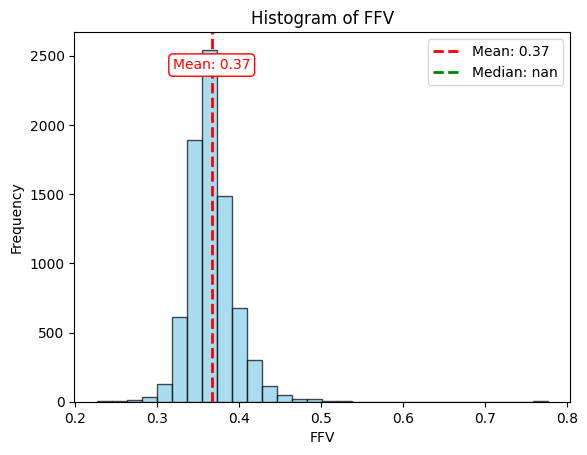

In [36]:
if regression:
    # Histogram for continuous target
    plt.hist(train[target], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

    # Calculate mean and median
    mean_value = np.mean(train[target])
    median_value = np.median(train[target])

    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

    # Add text annotations
    plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
    plt.text(median_value, plt.ylim()[1] * 0.8, f'Median: {median_value:.2f}', color='green', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

    # Labels and title
    plt.xlabel(target)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {target}")
    plt.legend()

else:
    # Pie chart for categorical target
    class_counts = train[target].value_counts()
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title(f"Distribution of {target}")

plt.show()

In [ ]:
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

#### Numeric

In [ ]:
# Calculate the number of rows needed for the subplots
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each continuous column and plot the histograms
for i, col in enumerate(numeric_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins = round(range_val / bin_size)

    # Plot the histograms
    axs[i].hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    axs[i].hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
if regression:
    # Determine number of rows for subplots (3 columns per row)
  num_rows = (len(numeric_cols) + 2) // 3

  # Create subplots
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

  # Flatten the axs array for easy iteration
  axs = axs.flatten()

  # Loop through each numeric column and plot the scatter plot
  for i, col in enumerate(numeric_cols):
      axs[i].scatter(train[col], train[target], alpha=0.5, color='blue', edgecolors='black')
      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)

  # Remove any unused subplots
  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

else:
  classes = train[target].unique()

  for col in numeric_cols:
    plt.figure(figsize=(10, 6))

    # Gather data grouped by target
    data_to_plot = [train[train[target] == tgt][col].values for tgt in classes]

    # Create boxplot and get the dictionary of plot elements
    box = plt.boxplot(data_to_plot, labels=classes)

    # Annotate the median values
    for i, median_line in enumerate(box['medians']):
        x, y = median_line.get_xdata(), median_line.get_ydata()
        median_value = y[0]  # both y[0] and y[1] are the same for a horizontal line
        plt.text(x[0], median_value, f'{median_value:.2f}',
                ha='center', va='bottom', fontsize=9, color='blue')

    plt.title(f'Boxplot of {col} by {target}')
    plt.xlabel(target)
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
if regression:
  corr = train[numeric_cols + [target]].corr()
  plt.figure(figsize = (10, 8), dpi = 300)
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True, annot_kws = {'size' : 7}, vmin = -1, vmax = 1)
  plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
  plt.show()

else:
  X = train[numeric_cols].fillna(-999)
  y = train[target]

  # Compute ANOVA F-value
  f_vals, p_vals = f_classif(X, y)

  # Create DataFrame
  anova_df = pd.DataFrame({
      'Feature': X.columns.tolist(),
      'F_value': f_vals,
      'p_value': p_vals
  }).sort_values('F_value', ascending=False)

  # Plot
  plt.figure(figsize=(10, 6))
  plt.barh(anova_df['Feature'], anova_df['F_value'], color='skyblue')
  plt.xlabel('ANOVA F-value')
  plt.title('ANOVA Feature Importance for Multiclass Target')
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

#### Categorical

In [ ]:
if regression:
  fig, axs = plt.subplots(len(categorical_cols), 1, figsize=(10, len(categorical_cols) * 4))

  for i, col in enumerate(categorical_cols):
      # Get the top 10 most frequent categories
      top_categories = train[col].value_counts().nlargest(10).index

      # Filter train data to only include top categories
      filtered_train = train[train[col].isin(top_categories)]

      # Create box plot
      axs[i].boxplot(
          [filtered_train[filtered_train[col] == category][target] for category in top_categories],
          labels=top_categories
      )

      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)
      axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

  plt.tight_layout()
  plt.show()

else:
  for col in categorical_cols:
    crosstab = pd.crosstab(train[col], train[target], normalize='index')  # row-wise percent
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title(f'Distribution of {target} by {col}')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
if regression:
  from scipy.stats import kruskal

  kruskal_results = {}

  for col in categorical_cols:
      groups = [train[train[col] == category][target] for category in train[col].unique()]
      if len(groups) > 1:
          stat, p = kruskal(*groups)
          kruskal_results[col] = {"Kruskal-Wallis Statistic": stat, "p-value": p}

  # Convert to DataFrame
  kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index")
  display(kruskal_df.sort_values(by="Kruskal-Wallis Statistic", ascending=False))

# Higher statistic → Stronger categorical effect

# Lower p-value → More significant relationship

else:
  chi2_results = {}

  # Encode the multiclass target
  y_encoded = LabelEncoder().fit_transform(train[target])

  for col in categorical_cols:
      # Encode the categorical feature
      x_encoded = LabelEncoder().fit_transform(train[col]).reshape(-1, 1)

      # Run chi-squared test
      stat, p = chi2(x_encoded, y_encoded)
      chi2_results[col] = {"Chi2 Statistic": stat[0], "p-value": p[0]}

  # Convert to DataFrame
  chi2_df = pd.DataFrame.from_dict(chi2_results, orient="index")
  display(chi2_df.sort_values(by="Chi2 Statistic", ascending=False))

### Unique

In [38]:
train.describe()

,Tg,FFV,Tc,Density,Rg
count,556.000000,7892.000000,738.000000,610.000000,611.000000
mean,99.765367,0.367007,0.256624,0.986185,16.395963
std,111.162938,0.029067,0.089934,0.146166,4.559086
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,16.754893,0.349598,0.186000,0.891256,12.528396
50%,77.913615,0.364004,0.236500,0.949296,15.040386
75%,164.908632,0.380173,0.330875,1.062864,20.392752
max,472.250000,0.777097,0.526000,1.840999,34.487303


In [39]:
train[train['FFV'] >= 0.5]

,SMILES,Tg,FFV,Tc,Density,Rg
177272960,*c1ccc(*)[nH]1,NaN,0.563897,NaN,NaN,NaN
180321996,*CCCCCCCCCC[N+](*)(C)C,NaN,0.769315,NaN,NaN,NaN
370833911,*CCSSSS*,NaN,0.528203,NaN,NaN,NaN
637669265,*CC(*)C(=O)NCCC[N+](C)(C)C,NaN,0.687057,NaN,NaN,NaN
660253930,*c1ccc(-c2sc(-c3ccc(-c4cc(CCCC)c(*)s4)cc3)cc2C...,NaN,0.500778,NaN,NaN,NaN
713393124,*CC(*)C(=O)N1CC[NH+](CC)CC1,NaN,0.650907,NaN,NaN,NaN
750049504,*c1ccc(-c2sc(-c3ccc(-c4cc(SCCCC)c(*)s4)cc3)cc2...,NaN,0.511978,NaN,NaN,NaN
806978622,*CC(*)O[N+](=O)[O-],NaN,0.774066,0.1585,1.305302,17.272314
852184111,*c1cc(C)c(*)s1,NaN,0.516864,NaN,NaN,NaN
1201617221,*c1ccc(-c2sc(-c3cc(SCCCC)c(*)s3)cc2SCCCC)cc1,NaN,0.507618,NaN,NaN,NaN


## Feature Egnineering RDKIT

In [17]:
# A small function to handle potential errors with invalid SMILES strings.
def smiles_to_features(smiles_string, n_bits=1024):
    """
    Takes a SMILES string and returns a dictionary of RDKit molecular
    descriptors and Morgan fingerprints.
    """
    try:
        # Create a molecule object from the SMILES string
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            return None # Return None for invalid SMILES

        # Calculate a variety of molecular descriptors
        features = {
            'MolWt': Descriptors.MolWt(mol),
            'ExactMolWt': Descriptors.ExactMolWt(mol),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
            'NumAromaticRings': Descriptors.NumAromaticRings(mol),
            'TPSA': Descriptors.TPSA(mol),
            'BalabanJ': Descriptors.BalabanJ(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
            'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
        }

        # Generate Morgan fingerprints using the modern MorganGenerator
        # The MorganGenerator is the recommended way to generate fingerprints.
        # It's more efficient and flexible.
        gen = GetMorganGenerator(radius=2, fpSize=n_bits)
        morgan_fp = gen.GetFingerprint(mol).ToBitString()

        # Add the fingerprint as a new column. We store it as a string to simplify the DataFrame.
        # It can be converted back to an array for modeling later.
        features['MorganFP'] = morgan_fp

        return features

    except Exception as e:
        print(f"Error processing SMILES '{smiles_string}': {e}")
        return None

In [21]:
rdk_feats = pd.DataFrame(train['SMILES'].apply(lambda x : smiles_to_features(x)).to_list(),  index=train.index)

In [28]:
train = pd.concat([train, rdk_feats], axis = 1)

In [31]:
rdk_feats_test = pd.DataFrame(test['SMILES'].apply(lambda x : smiles_to_features(x)).to_list(),  index=test.index)
test = pd.concat([test, rdk_feats_test ], axis = 1)

## Tree Models

#### HGBG

In [ ]:
# Test targets
y_test = test[['Tg', 'FFV', 'Tc', 'Density', 'Rg']].to_numpy()

task_names = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
models = {}
y_pred = np.zeros_like(y_test)

# Train one random forest per task
for idx, name in enumerate(task_names):
    print('Training random forest for the task:', name)
    y_col = y_dev[:, idx]
    mask  = ~np.isnan(y_col)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_dev_feats[mask], y_col[mask])
    models[name] = rf
    # Predict on test set
    y_pred[:, idx] = rf.predict(X_test_feats)

# Compute MSE per task, skipping NaNs
mse_per_task = {}
for i, name in enumerate(task_names):
    print('Predicting for the task:', name)
    mask = ~np.isnan(y_test[:, i])
    if mask.sum() > 0:
        mse = mean_squared_error(y_test[mask, i], y_pred[mask, i])
        mse_per_task[name] = mse
    else:
        mse_per_task[name] = np.nan

print("MSE per task:")
for name, mse in mse_per_task.items():
    print(f"  {name}: {mse:.4f}")

# Compute overall MSE across all tasks, skipping NaNs
mask_all = ~np.isnan(y_test)
y_true_flat = y_test[mask_all]
y_pred_flat = y_pred[mask_all]
mse_overall = mean_squared_error(y_true_flat, y_pred_flat)
print(f"Overall MSE: {mse_overall:.4f}")

#### XGB

## LSTM

## Graph NN

## Save to Github

In [33]:
!git config --global user.email "abishpius@gmail.com"
!git config --global user.name "Abish Pius"

In [ ]:
from google.colab import userdata
import requests

token = userdata.get('github')
repo_name = "NeuralIPS-Open-Polymer"
username = "abishpius"
message = "Kaggle Competition NeuralIPS-Open-Polymer Starter"
notebook_name = "Kaggle_NerualIPS_Open_Polymer.ipynb"

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github+json"
}

# === CHECK IF REPO EXISTS ===
check_url = f"https://api.github.com/repos/{username}/{repo_name}"
check_resp = requests.get(check_url, headers=headers)

if check_resp.status_code == 200:
    print(f"❌ Repo '{repo_name}' already exists at: https://github.com/{username}/{repo_name}")
else:
    # === CREATE REPO ===
    create_url = "https://api.github.com/user/repos"
    payload = {
        "name": repo_name,
        "auto_init": True,
        "private": False  # change to True if you want a private repo
    }

    create_resp = requests.post(create_url, headers=headers, json=payload)

    if create_resp.status_code == 201:
        print(f"✅ Repo '{repo_name}' created successfully.")

        # === UPDATE README.md ===
        import base64

        update_url = f"https://api.github.com/repos/{username}/{repo_name}/contents/README.md"

        encoded = base64.b64encode(readme_text.encode()).decode()
        update_payload = {
            "message": message,
            "content": encoded,
            "sha": requests.get(update_url, headers=headers).json()["sha"]
        }

        update_resp = requests.put(update_url, headers=headers, json=update_payload)

        if update_resp.status_code == 200 or update_resp.status_code == 201:
            print("✅ README.md updated with custom text.")
        else:
            print("⚠️ Failed to update README.md:", update_resp.json())

    else:
        print("❌ Repo creation failed:", create_resp.json())

In [ ]:
!git clone https://{token}@github.com/{username}/{repo_name}.git

# === MOVE NOTEBOOK ===
import shutil
shutil.copy(f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}", f"/content/{repo_name}/{notebook_name}")

# === COMMIT TO REPO ===
%cd {repo_name}
!git add {notebook_name}
!git commit -m "EDA initial"
!git push